In [ ]:
# ruff: noqa: T201, T203
from __future__ import annotations

import os
from pathlib import Path

if Path.cwd().name == "notebooks":
    os.chdir("..")

import logging

import pandas as pd
from dotenv import load_dotenv
from tqdm import tqdm

from config.config import DATA_DIR, RUN_DIR
from config.runs_vars import SUBSET_TO_DATASET_MAP
from src.constants import PAIRS_SEPARATOR
from src.evaluate import (
    analyze_results,
    get_predictions_with_gt,
    plot_usage_histograms,
    read_run_metrics_df,
    store_run_metrics_df,
)
from src.formatting import (
    format_oracle_pairs_filepath,
    format_run_path,
    format_storing_pathes_from_run_path,
    format_subsets_ontologies_paths,
)
from src.LLM_servers.openai import OpenAIServer
from src.onto_access import OntologyAccess
from src.onto_object import OntologyEntryAttr
from src.processing import load_precomputed_oracle_pairs, parallel_samples_process, save_oracle_pairs_with_prompts
from src.prompts.prompts import (
    prompt_direct_entity,
    prompt_direct_entity_ontological,
    prompt_direct_entity_with_synonyms,
    prompt_sequential_hierarchy,
    prompt_sequential_hierarchy_ontological,
    prompt_sequential_hierarchy_with_synonyms,
)
from src.prompts.system import BASELINE_INITIALIZATION_MESSAGE
from src.utils import read_oracle_pairs, save_run_results

logging.getLogger().setLevel(logging.WARNING)
load_dotenv()

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
DATASET_NAME, SET_NAME = "bioml-2024", "snomed-fma.body" # "snomed-ncit.neoplas", "snomed-ncit.pharm"

src_onto_path, tgt_onto_path = format_subsets_ontologies_paths(DATASET_NAME, SET_NAME)
src_onto_path, tgt_onto_path

(PosixPath('data/bioml-2024/snomed-fma.body/snomed.body.owl'),
 PosixPath('data/bioml-2024/snomed-fma.body/fma.body.owl'))

In [8]:
EXP_NAMES_TO_PROMPT_FUNCTIONS = {
    prompt_function.__name__.replace("prompt_", ""): prompt_function
    for prompt_function in [
        prompt_direct_entity,
        prompt_direct_entity_ontological,
        prompt_sequential_hierarchy,
        prompt_sequential_hierarchy_ontological,
        prompt_direct_entity_with_synonyms,
        prompt_sequential_hierarchy_with_synonyms,
    ]
}

In [9]:
onto_src = OntologyAccess(src_onto_path, annotate_on_init=True)
onto_tgt = OntologyAccess(tgt_onto_path, annotate_on_init=True)

* Owlready2 * Creating new ontology fma.body <data/bioml-2024/snomed-fma.body/fma.body.owl#>.
* Owlready2 * ADD TRIPLE data/bioml-2024/snomed-fma.body/fma.body.owl http://www.w3.org/1999/02/22-rdf-syntax-ns#type http://www.w3.org/2002/07/owl#Ontology
* Owlready2 *     ...loading ontology fma.body from data/bioml-2024/snomed-fma.body/fma.body.owl...


* Owlready2 * Reseting property ann.use_in_alignment: new triples are now available.


* Owlready2 *     ...219 properties found: adheres_to, connected_to, adjacent_to, afferent_to, efferent_to, anatomical_entity_observed, anatomical_landmark_for, has_anatomical_landmark, anatomical_plane, anterior_to, has_location, anteroinferior_to, anterolateral_to, anteromedial_to, anterosuperior_to, arterial_supply, arterial_supply_of, articulates_with, attaches_to, receives_attachment_from, attributed_constitutional_part, attributed_development, attributed_part, attributed_regional_part, bounded_by, bounds, branch, regional_part, branch_of, branch__continuity_, regional_part_of, connecting_part, connection_type, constitutional_part, part, constitutional_part_of, part_of, contained_in, contains, continuous_distally_with, continuous_with, continuous_proximally_with, corresponds_to, derives, develops_into, derives_from, develops_from, development_type, developmental_fusion, developmental_stage_of, has_developmental_stage, direct_left_of, direct_right_of, distal_to, drains_into, receiv

### Pre-Validation

In [10]:
src_entity, tgt_entity = read_oracle_pairs(format_oracle_pairs_filepath(DATASET_NAME, SET_NAME))[0]
try:
    src_entity, tgt_entity = OntologyEntryAttr(src_entity, onto_src), OntologyEntryAttr(tgt_entity, onto_tgt)
except AssertionError:
    src_entity, tgt_entity = OntologyEntryAttr(tgt_entity, onto_src), OntologyEntryAttr(src_entity, onto_tgt)

print(src_entity)
print(tgt_entity)

for name, prompt_function in EXP_NAMES_TO_PROMPT_FUNCTIONS.items():
    print(f"Prompt function: {name}")
    print(prompt_function(src_entity, tgt_entity))
    print("=" * 50)

{'class': id.27140001, 'uri': 'http://snomed.info/id/27140001', 'preffered_names': {'Structure of gyrus fornicatus', 'Structure of gyrus fornicatus (body structure)'}, 'synonyms': {'Gyrus fornicatus'}, 'all_names': {'Structure of gyrus fornicatus', 'Structure of gyrus fornicatus (body structure)', 'Gyrus fornicatus'}, 'parents': {owl.Thing}, 'children': {id.369120003}}
{'class': fma.fma72719, 'uri': 'http://purl.org/sig/ont/fma/fma72719', 'preffered_names': {'Limbic lobe'}, 'synonyms': {'fma72719'}, 'all_names': {'Limbic lobe'}, 'parents': {fma.fma67135, fma.fma82472, fma.fma256237, fma.fma61820, owl.Thing, fma.fma62374, fma.fma61996, fma.fma305751, fma.fma55676, fma.fma86140, fma.fma67165, fma.fma67619, fma.fma61775, fma.fma62955, fma.fma61823}, 'children': {fma.fma72980, fma.fma72981}}
Prompt function: direct_entity
We have two entities from different biomedical ontologies.
The first one is "Structure of gyrus fornicatus, Structure of gyrus fornicatus (body structure)", which belongs

In [13]:
for name, prompt_function in EXP_NAMES_TO_PROMPT_FUNCTIONS.items():
    print(f"Prompt function: {name}")
    oracle_candidate_pairs = load_precomputed_oracle_pairs(DATASET_NAME, SET_NAME, prompt_function)
    print(oracle_candidate_pairs[0], sep="\n")


Prompt function: direct_entity
('http://human.owl#NCI_C32658', 'http://mouse.owl#MA_0002684', 'We have two entities from different biomedical ontologies.\nThe first one is "stomach muscularis mucosa", which belongs to the broader category "Thing"\nThe second one is "Gastric_Muscularis_Mucosa", which belongs to the broader category "Gastric_Mucosa"\n\nDo they mean the same thing? Respond with "True" or "False".')
Prompt function: direct_entity_ontological
('http://human.owl#NCI_C32658', 'http://mouse.owl#MA_0002684', 'Analyze the following entities, each originating from a distinct biomedical ontology.\nYour task is to assess whether they represent the **same ontological concept**, considering both their semantic meaning and hierarchical position.\n\n1. Source entity: "stomach muscularis mucosa"\n\t- Direct ontological parent: Thing\n\n2. Target entity: "Gastric_Muscularis_Mucosa"\n\t- Direct ontological parent: Gastric_Mucosa\n\nAre these entities **ontologically equivalent** within th

### Pre-Processing

In [11]:
ALL_DATASET_NAMES = {
    # "anatomy": ["mouse-human"],
    "bioml-2024": ["snomed-fma.body", "snomed-ncit.neoplas", "snomed-ncit.pharm", "ncit-doid", "omim-ordo"],
    # "largebio": ["fma-nci", "fma-snomed", "snomed-nci"],
}
PAIRS_WITH_PROMPTS_SUBDIR = "oracle_pairs"
prompt_functions = list(EXP_NAMES_TO_PROMPT_FUNCTIONS.values())

for dataset_name, set_names in ALL_DATASET_NAMES.items():
    for set_name in set_names:
        try:
            ontologies = []
            for onto_path in tqdm(
                format_subsets_ontologies_paths(dataset_name, set_name),
                desc=f"Loading ontologies: {dataset_name} - {set_name}",
            ):
                ontologies.append(OntologyAccess(onto_path, annotate_on_init=True))

            pairs_path = format_oracle_pairs_filepath(dataset_name, set_name)
            oracle_pairs_dir = DATA_DIR / dataset_name / set_name / PAIRS_WITH_PROMPTS_SUBDIR

            pairs_with_prompts_df = save_oracle_pairs_with_prompts(
                pairs_path, *ontologies, prompt_functions, oracle_pairs_dir, PAIRS_SEPARATOR, max_workers=2
            )
        except Exception as e:  # noqa: BLE001
            print(f"Error processing {dataset_name} - {set_name}: {e}")
            continue

Loading ontologies: bioml-2024 - snomed-fma.body:   0%|          | 0/2 [00:00<?, ?it/s]

Adding prompts: 100%|██████████| 2081/2081 [59:10<00:00,  1.71s/it]  
Loading ontologies: bioml-2024 - snomed-ncit.neoplas:   0%|          | 0/2 [00:00<?, ?it/s]* Owlready2 * Creating new ontology snomed.neoplas <data/bioml-2024/snomed-ncit.neoplas/snomed.neoplas.owl#>.
* Owlready2 * ADD TRIPLE data/bioml-2024/snomed-ncit.neoplas/snomed.neoplas.owl http://www.w3.org/1999/02/22-rdf-syntax-ns#type http://www.w3.org/2002/07/owl#Ontology
* Owlready2 *     ...loading ontology snomed.neoplas from data/bioml-2024/snomed-ncit.neoplas/snomed.neoplas.owl...


* Owlready2 * Reseting property id.762705008: new triples are now available.
* Owlready2 * Reseting property id.1003703000: new triples are now available.
* Owlready2 * Reseting property id.1003735000: new triples are now available.
* Owlready2 * Reseting property id.1148965004: new triples are now available.
* Owlready2 * Reseting property id.1148967007: new triples are now available.
* Owlready2 * Reseting property id.1148968002: new triples are now available.
* Owlready2 * Reseting property id.1148969005: new triples are now available.
* Owlready2 * Reseting property id.1149366004: new triples are now available.
* Owlready2 * Reseting property id.1149367008: new triples are now available.
* Owlready2 * Reseting property id.116676008: new triples are now available.
* Owlready2 * Reseting property id.116686009: new triples are now available.
* Owlready2 * Reseting property id.118168003: new triples are now available.
* Owlready2 * Reseting property id.118169006: new triples are now av

* Owlready2 *     ...141 properties found: 1003703000, 762705008, 1003735000, 1148965004, 1148967007, 1148968002, 1148969005, 1149366004, 1149367008, 116676008, 116686009, 118168003, 118169006, 118170007, 118171006, 127489000, 762951001, 738774007, 131195008, 246075003, 47429007, 246090004, 246093002, 246112005, 246454002, 246456000, 246501002, 246513007, 246514001, 255234002, 726633004, 260507000, 260686004, 260870009, 263502005, 272741003, 288556008, 320091000221107, 363589002, 363698007, 363699004, 405815000, 363700003, 405816004, 363701004, 363702006, 363703001, 363704007, 363705008, 363709002, 363710007, 363713009, 363714003, 370129005, 370130000, 370131001, 370132008, 370133003, 370134009, 370135005, 371881003, 405813007, 405814001, 408729009, 408730004, 408731000, 408732007, 410675002, 411116001, 418775008, 419066007, 424226004, 424244007, 424361007, 424876005, 425391005, 42752001, 609096000, 704319004, 704320005, 704321009, 704322002, 704323007, 704324001, 704325000, 704326004,

* Owlready2 * Reseting property ann.use_in_alignment: new triples are now available.


* Owlready2 *     ...226 properties found: R100, R101, R102, R103, R104, R105, R106, R107, R108, R110, R111, R112, R113, R114, R115, R116, R122, R123, R124, R125, R126, R130, R131, R132, R133, R135, R136, R137, R138, R139, R140, R141, R142, R145, R146, R150, R153, R155, R156, R158, R159, R160, R163, R165, R166, R167, R168, R169, R170, R171, R172, R173, R174, R175, R176, R177, R178, R179, R180, R181, R182, R23, R24, R25, R26, R27, R28, R29, R30, R31, R32, R34, R35, R36, R37, R38, R39, R40, R41, R42, R44, R45, R46, R47, R48, R49, R50, R51, R52, R53, R54, R66, R72, R81, R82, R88, R89, comment, label, versionInfo, use_in_alignment, P207, P315, P367, NHC0, P106, P107, P108, P90, P97, P98, P383, P384, P378, P322, P363, P385, P386, P325, P371, P381, P102, P171, P100, P369, P375, P393, P394, P395, P396, P208, P397, P310, P366, A1, A10, A11, A12, A13, A14, A15, A16, A17, A18, A19, A2, A20, A21, A22, A23, A24, A25, A26, A27, A28, A29, A3, A30, A33, A34, A4, A5, A6, A7, A8, A9, P101, P167, P175, 

* Owlready2 * Reseting property id.762705008: new triples are now available.
* Owlready2 * Reseting property id.1003703000: new triples are now available.
* Owlready2 * Reseting property id.1003735000: new triples are now available.
* Owlready2 * Reseting property id.1148965004: new triples are now available.
* Owlready2 * Reseting property id.1148967007: new triples are now available.
* Owlready2 * Reseting property id.1148968002: new triples are now available.
* Owlready2 * Reseting property id.1148969005: new triples are now available.
* Owlready2 * Reseting property id.1149366004: new triples are now available.
* Owlready2 * Reseting property id.1149367008: new triples are now available.
* Owlready2 * Reseting property id.116676008: new triples are now available.
* Owlready2 * Reseting property id.116686009: new triples are now available.
* Owlready2 * Reseting property id.118168003: new triples are now available.
* Owlready2 * Reseting property id.118169006: new triples are now av

* Owlready2 *     ...141 properties found: 1003703000, 762705008, 1003735000, 1148965004, 1148967007, 1148968002, 1148969005, 1149366004, 1149367008, 116676008, 116686009, 118168003, 118169006, 118170007, 118171006, 127489000, 762951001, 738774007, 131195008, 246075003, 47429007, 246090004, 246093002, 246112005, 246454002, 246456000, 246501002, 246513007, 246514001, 255234002, 726633004, 260507000, 260686004, 260870009, 263502005, 272741003, 288556008, 320091000221107, 363589002, 363698007, 363699004, 405815000, 363700003, 405816004, 363701004, 363702006, 363703001, 363704007, 363705008, 363709002, 363710007, 363713009, 363714003, 370129005, 370130000, 370131001, 370132008, 370133003, 370134009, 370135005, 371881003, 405813007, 405814001, 408729009, 408730004, 408731000, 408732007, 410675002, 411116001, 418775008, 419066007, 424226004, 424244007, 424361007, 424876005, 425391005, 42752001, 609096000, 704319004, 704320005, 704321009, 704322002, 704323007, 704324001, 704325000, 704326004,

* Owlready2 * Reseting property ann.use_in_alignment: new triples are now available.
* Owlready2 * Reseting property ncit.neoplas.R100: new triples are now available.
* Owlready2 * Reseting property ncit.neoplas.R101: new triples are now available.
* Owlready2 * Reseting property ncit.neoplas.R102: new triples are now available.
* Owlready2 * Reseting property ncit.neoplas.R103: new triples are now available.
* Owlready2 * Reseting property ncit.neoplas.R104: new triples are now available.
* Owlready2 * Reseting property ncit.neoplas.R105: new triples are now available.
* Owlready2 * Reseting property ncit.neoplas.R106: new triples are now available.
* Owlready2 * Reseting property ncit.neoplas.R107: new triples are now available.
* Owlready2 * Reseting property ncit.neoplas.R108: new triples are now available.
* Owlready2 * Reseting property ncit.neoplas.R110: new triples are now available.
* Owlready2 * Reseting property ncit.neoplas.R111: new triples are now available.
* Owlready2 *

* Owlready2 *     ...227 properties found: R100, R101, R102, R103, R104, R105, R106, R107, R108, R110, R111, R112, R113, R114, R115, R116, R122, R123, R124, R125, R126, R130, R131, R132, R133, R135, R136, R137, R138, R139, R140, R141, R142, R145, R146, R150, R153, R155, R156, R158, R159, R160, R163, R165, R166, R167, R168, R169, R170, R171, R172, R173, R174, R175, R176, R177, R178, R179, R180, R181, R182, R23, R24, R25, R26, R27, R28, R29, R30, R31, R32, R34, R35, R36, R37, R38, R39, R40, R41, R42, R44, R45, R46, R47, R48, R49, R50, R51, R52, R53, R54, R66, R72, R81, R82, R88, R89, comment, label, versionInfo, use_in_alignment, P207, P315, P367, NHC0, P106, P107, P108, P90, P97, P98, P383, P384, P378, P322, P363, P385, P386, P325, P371, P381, P102, P171, P100, P369, P375, P393, P394, P395, P396, P208, P397, P310, P366, A1, A10, A11, A12, A13, A14, A15, A16, A17, A18, A19, A2, A20, A21, A22, A23, A24, A25, A26, A27, A28, A29, A3, A30, A33, A34, A4, A5, A6, A7, A8, A9, P101, P167, P175, 

* Owlready2 * Reseting property ann.use_in_alignment: new triples are now available.
* Owlready2 * Reseting property ncit.neoplas.R100: new triples are now available.
* Owlready2 * Reseting property ncit.neoplas.R101: new triples are now available.
* Owlready2 * Reseting property ncit.neoplas.R102: new triples are now available.
* Owlready2 * Reseting property ncit.neoplas.R103: new triples are now available.
* Owlready2 * Reseting property ncit.neoplas.R104: new triples are now available.
* Owlready2 * Reseting property ncit.neoplas.R105: new triples are now available.
* Owlready2 * Reseting property ncit.neoplas.R106: new triples are now available.
* Owlready2 * Reseting property ncit.neoplas.R107: new triples are now available.
* Owlready2 * Reseting property ncit.neoplas.R108: new triples are now available.
* Owlready2 * Reseting property ncit.neoplas.R110: new triples are now available.
* Owlready2 * Reseting property ncit.neoplas.R111: new triples are now available.
* Owlready2 *

* Owlready2 *     ...206 properties found: R100, R101, R102, R103, R104, R105, R106, R107, R108, R110, R111, R112, R113, R114, R115, R116, R122, R123, R124, R125, R126, R130, R131, R132, R133, R135, R136, R137, R138, R139, R140, R141, R142, R145, R146, R150, R153, R155, R156, R158, R159, R160, R163, R165, R166, R167, R168, R169, R170, R171, R172, R173, R174, R175, R176, R177, R178, R179, R180, R181, R182, R23, R24, R25, R26, R27, R28, R29, R30, R31, R32, R34, R35, R36, R37, R38, R39, R40, R41, R42, R44, R45, R46, R47, R48, R49, R50, R51, R52, R53, R54, R66, R72, R81, R82, R88, R89, comment, label, versionInfo, use_in_alignment, P207, P367, NHC0, P106, P107, P108, P90, P97, P98, P383, P384, P378, P322, P363, P385, P386, P325, P371, P381, P102, P171, P100, P369, P393, P394, P395, P396, P208, P310, P366, A1, A10, A11, A12, A13, A14, A15, A2, A3, A4, A5, A6, A7, A8, A9, P101, P167, P175, P200, P201, P203, P204, P205, P210, P211, P215, P216, P302, P316, P317, P319, P320, P321, P329, P330, P

* Owlready2 * Reseting property ann.use_in_alignment: new triples are now available.


* Owlready2 *     ...49 properties found: complicated_by, composed_of, derives_from, has_material_basis_in, has_symptom, inheres_in, is_a, located_in, occurs_with, part_of, realized_by, realized_by_supression_with, results_in, results_in_formation_of, transmitted_by, comment, label, deprecated, use_in_alignment, hasExactSynonym, hasRelatedSynonym, IAO_0000115, hasOBONamespace, IAO_0000231, IAO_0100001, DO_AGR_slim, SubsetProperty, DO_FlyBase_slim, DO_MGI_slim, DO_cancer_slim, DO_rare_slim, GOLD, NCIthesaurus, TopNodes_DOcancerslim, gram-negative_bacterial_infectious_disease, gram-positive_bacterial_infectious_disease, sexually_transmitted_infectious_disease, tick-borne_infectious_disease, zoonotic_infectious_disease, created_by, creation_date, date, default-namespace, hasAlternativeId, hasNarrowSynonym, hasOBOFormatVersion, id, inSubset, saved-by
Loading ontologies: bioml-2024 - omim-ordo:   0%|          | 0/2 [00:00<?, ?it/s]* Owlready2 * Creating new ontology omim <data/bioml-2024/om

* Owlready2 * Reseting property ann.use_in_alignment: new triples are now available.
* Owlready2 * Reseting property oboInOwl.hasExactSynonym: new triples are now available.
* Owlready2 * Reseting property obo.IAO_0100001: new triples are now available.


* Owlready2 *     ...12 properties found: label, use_in_alignment, hasExactSynonym, IAO_0100001, IAO_0000142, RO_0002200, RO_0002525, RO_0003303, consider, hasSynonymType, exactMatch, category
Loading ontologies: bioml-2024 - omim-ordo:  50%|█████     | 1/2 [09:40<09:40, 580.30s/it]* Owlready2 * Creating new ontology ordo <data/bioml-2024/omim-ordo/ordo.owl#>.
* Owlready2 * ADD TRIPLE data/bioml-2024/omim-ordo/ordo.owl http://www.w3.org/1999/02/22-rdf-syntax-ns#type http://www.w3.org/2002/07/owl#Ontology
* Owlready2 *     ...loading ontology ordo from data/bioml-2024/omim-ordo/ordo.owl...


* Owlready2 * Reseting property ann.use_in_alignment: new triples are now available.


* Owlready2 *     ...41 properties found: BFO_0000050, Orphanet_317343, Orphanet_317344, Orphanet_317345, Orphanet_317346, Orphanet_317348, Orphanet_317349, Orphanet_327767, Orphanet_410295, Orphanet_410296, Orphanet_465410, Orphanet_C016, Orphanet_C017, Orphanet_C020, Orphanet_C022, Orphanet_C025, Orphanet_C026, Orphanet_C027, Orphanet_C024, Orphanet_C028, Orphanet_C029, Orphanet_C030, Orphanet_C032, Orphanet_C040, label, versionInfo, use_in_alignment, alternative_term, ECO_0000205, ECO_0000218, creator, created, license, modified, definition, definition_citation, reason_for_obsolescence, symbol, notation, permits, requires
Adding prompts: 100%|██████████| 1464/1464 [16:49<00:00,  1.45it/s]


### Run experiments


In [ ]:
MAX_WORKERS = 150
MODELS = ["gemini-2.0-flash-lite"]  # "gpt-4o-mini"

DATASETS_MAP = {
    # "anatomy": ["mouse-human"],
    "bioml-2024": ["snomed-fma.body", "snomed-ncit.neoplas", "snomed-ncit.pharm"], # "ncit-doid", "omim-ordo"],
    "largebio": ["fma-snomed", "snomed-nci"], # "fma-nci"]
}
onto_src, onto_tgt = None, None

Processing Lines prompt_direct_entity: 100%|██████████| 2081/2081 [00:52<00:00, 39.73it/s] 


Mean input tockens: 122.4
Mean output tockens: 9.0
Total input tockens: 254798
Total output tockens: 18729
Accuracy: 0.575
Precision: 0.471
Recall: 0.877
F1 Score: 0.613




Processing Lines prompt_direct_entity_ontological: 100%|██████████| 2081/2081 [00:50<00:00, 40.83it/s] 


Mean input tockens: 159.5
Mean output tockens: 9.0
Total input tockens: 331955
Total output tockens: 18729
Accuracy: 0.572
Precision: 0.462
Recall: 0.695
F1 Score: 0.555




Processing Lines prompt_sequential_hierarchy: 100%|██████████| 2081/2081 [01:05<00:00, 31.83it/s]


Mean input tockens: 140.8
Mean output tockens: 9.0
Total input tockens: 292938
Total output tockens: 18729
Accuracy: 0.554
Precision: 0.457
Recall: 0.876
F1 Score: 0.601




Processing Lines prompt_sequential_hierarchy_ontological: 100%|██████████| 2081/2081 [00:52<00:00, 39.53it/s] 


Mean input tockens: 197.6
Mean output tockens: 9.0
Total input tockens: 411176
Total output tockens: 18729
Accuracy: 0.602
Precision: 0.456
Recall: 0.203
F1 Score: 0.281




Processing Lines prompt_direct_entity_with_synonyms: 100%|██████████| 2081/2081 [01:17<00:00, 27.02it/s] 


Mean input tockens: 129.8
Mean output tockens: 9.0
Total input tockens: 270206
Total output tockens: 18729
Accuracy: 0.602
Precision: 0.490
Recall: 0.895
F1 Score: 0.633




Processing Lines prompt_sequential_hierarchy_with_synonyms: 100%|██████████| 2081/2081 [10:06<00:00,  3.43it/s]


Mean input tockens: 156.7
Mean output tockens: 9.0
Total input tockens: 326028
Total output tockens: 18729
Accuracy: 0.624
Precision: 0.505
Recall: 0.892
F1 Score: 0.645




Processing Lines prompt_direct_entity: 100%|██████████| 1797/1797 [00:56<00:00, 31.58it/s] 


Mean input tockens: 114.4
Mean output tockens: 9.0
Total input tockens: 205629
Total output tockens: 16173
Accuracy: 0.531
Precision: 0.512
Recall: 0.809
F1 Score: 0.627




Processing Lines prompt_direct_entity_ontological: 100%|██████████| 1797/1797 [00:52<00:00, 34.16it/s] 


Mean input tockens: 151.5
Mean output tockens: 9.0
Total input tockens: 272245
Total output tockens: 16173
Accuracy: 0.563
Precision: 0.537
Recall: 0.742
F1 Score: 0.623




Processing Lines prompt_sequential_hierarchy: 100%|██████████| 1797/1797 [00:56<00:00, 32.04it/s]


Mean input tockens: 120.8
Mean output tockens: 9.0
Total input tockens: 217008
Total output tockens: 16173
Accuracy: 0.544
Precision: 0.520
Recall: 0.841
F1 Score: 0.643




Processing Lines prompt_sequential_hierarchy_ontological: 100%|██████████| 1797/1797 [01:01<00:00, 29.27it/s]


Mean input tockens: 178.6
Mean output tockens: 9.0
Total input tockens: 321014
Total output tockens: 16173
Accuracy: 0.597
Precision: 0.598
Recall: 0.529
F1 Score: 0.561




Processing Lines prompt_direct_entity_with_synonyms: 100%|██████████| 1797/1797 [00:49<00:00, 36.11it/s] 


Mean input tockens: 121.8
Mean output tockens: 9.0
Total input tockens: 218952
Total output tockens: 16173
Accuracy: 0.565
Precision: 0.533
Recall: 0.881
F1 Score: 0.664




Processing Lines prompt_sequential_hierarchy_with_synonyms: 100%|██████████| 1797/1797 [00:50<00:00, 35.43it/s]


Mean input tockens: 140.0
Mean output tockens: 9.0
Total input tockens: 251571
Total output tockens: 16173
Accuracy: 0.563
Precision: 0.532
Recall: 0.857
F1 Score: 0.657




Processing Lines prompt_direct_entity: 100%|██████████| 2081/2081 [01:01<00:00, 33.60it/s] 


Mean input tockens: 109.2
Mean output tockens: 9.0
Total input tockens: 227228
Total output tockens: 18729
Accuracy: 0.769
Precision: 0.818
Recall: 0.894
F1 Score: 0.854




Processing Lines prompt_direct_entity_ontological: 100%|██████████| 2081/2081 [01:03<00:00, 32.98it/s] 


Mean input tockens: 146.2
Mean output tockens: 9.0
Total input tockens: 304322
Total output tockens: 18729
Accuracy: 0.522
Precision: 0.817
Recall: 0.474
F1 Score: 0.600




Processing Lines prompt_sequential_hierarchy: 100%|██████████| 2081/2081 [01:01<00:00, 33.94it/s] 


Mean input tockens: 126.8
Mean output tockens: 9.0
Total input tockens: 263920
Total output tockens: 18729
Accuracy: 0.802
Precision: 0.819
Recall: 0.947
F1 Score: 0.878




Processing Lines prompt_sequential_hierarchy_ontological: 100%|██████████| 2081/2081 [01:06<00:00, 31.36it/s]


Mean input tockens: 184.1
Mean output tockens: 9.0
Total input tockens: 383043
Total output tockens: 18729
Accuracy: 0.345
Precision: 0.799
Recall: 0.177
F1 Score: 0.290




Processing Lines prompt_direct_entity_with_synonyms: 100%|██████████| 2081/2081 [01:01<00:00, 33.69it/s]


Mean input tockens: 110.8
Mean output tockens: 9.0
Total input tockens: 230559
Total output tockens: 18729
Accuracy: 0.785
Precision: 0.821
Recall: 0.916
F1 Score: 0.866




Processing Lines prompt_sequential_hierarchy_with_synonyms: 100%|██████████| 2081/2081 [01:10<00:00, 29.55it/s]


Mean input tockens: 133.7
Mean output tockens: 9.0
Total input tockens: 278311
Total output tockens: 18729
Accuracy: 0.787
Precision: 0.820
Recall: 0.920
F1 Score: 0.867




Processing Lines prompt_direct_entity: 100%|██████████| 5042/5042 [02:39<00:00, 31.52it/s] 


Mean input tockens: 129.1
Mean output tockens: 9.0
Total input tockens: 651087
Total output tockens: 45378
Accuracy: 0.742
Precision: 0.967
Recall: 0.749
F1 Score: 0.844




Processing Lines prompt_direct_entity_ontological: 100%|██████████| 5042/5042 [02:26<00:00, 34.44it/s]


Mean input tockens: 165.9
Mean output tockens: 9.0
Total input tockens: 836316
Total output tockens: 45378
Accuracy: 0.688
Precision: 0.970
Recall: 0.688
F1 Score: 0.805




Processing Lines prompt_sequential_hierarchy: 100%|██████████| 5042/5042 [02:25<00:00, 34.60it/s]


Mean input tockens: 174.6
Mean output tockens: 9.0
Total input tockens: 880114
Total output tockens: 45378
Accuracy: 0.839
Precision: 0.964
Recall: 0.860
F1 Score: 0.909




/home/sviat/code/rai/KG-LLM-Matching/src/evaluate.py:79: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(4, 4))
Processing Lines prompt_sequential_hierarchy_ontological: 100%|██████████| 5042/5042 [02:58<00:00, 28.29it/s]


Mean input tockens: 229.9
Mean output tockens: 9.0
Total input tockens: 1159044
Total output tockens: 45378
Accuracy: 0.459
Precision: 0.971
Recall: 0.435
F1 Score: 0.600




Processing Lines prompt_direct_entity_with_synonyms: 100%|██████████| 5042/5042 [02:31<00:00, 33.30it/s]


Mean input tockens: 127.1
Mean output tockens: 9.0
Total input tockens: 641004
Total output tockens: 45378
Accuracy: 0.711
Precision: 0.964
Recall: 0.717
F1 Score: 0.823




Processing Lines prompt_sequential_hierarchy_with_synonyms: 100%|██████████| 5042/5042 [02:39<00:00, 31.62it/s]


Mean input tockens: 170.9
Mean output tockens: 9.0
Total input tockens: 861493
Total output tockens: 45378
Accuracy: 0.849
Precision: 0.964
Recall: 0.870
F1 Score: 0.915




Processing Lines prompt_direct_entity: 100%|██████████| 4423/4423 [02:36<00:00, 28.20it/s]


Mean input tockens: 135.2
Mean output tockens: 9.0
Total input tockens: 598063
Total output tockens: 39807
Accuracy: 0.816
Precision: 0.935
Recall: 0.855
F1 Score: 0.893




Processing Lines prompt_direct_entity_ontological: 100%|██████████| 4423/4423 [02:26<00:00, 30.23it/s]


Mean input tockens: 172.0
Mean output tockens: 9.0
Total input tockens: 760734
Total output tockens: 39807
Accuracy: 0.768
Precision: 0.936
Recall: 0.798
F1 Score: 0.861




Processing Lines prompt_sequential_hierarchy: 100%|██████████| 4423/4423 [02:29<00:00, 29.52it/s]


Mean input tockens: 173.6
Mean output tockens: 9.0
Total input tockens: 768037
Total output tockens: 39807
Accuracy: 0.875
Precision: 0.931
Recall: 0.930
F1 Score: 0.931




Processing Lines prompt_sequential_hierarchy_ontological: 100%|██████████| 4423/4423 [02:38<00:00, 27.83it/s]


Mean input tockens: 229.2
Mean output tockens: 9.0
Total input tockens: 1013857
Total output tockens: 39807
Accuracy: 0.664
Precision: 0.937
Recall: 0.672
F1 Score: 0.783




Processing Lines prompt_direct_entity_with_synonyms: 100%|██████████| 4423/4423 [02:35<00:00, 28.38it/s] 


Mean input tockens: 133.2
Mean output tockens: 9.0
Total input tockens: 589233
Total output tockens: 39807
Accuracy: 0.821
Precision: 0.937
Recall: 0.859
F1 Score: 0.896




Processing Lines prompt_sequential_hierarchy_with_synonyms: 100%|██████████| 4423/4423 [02:10<00:00, 34.02it/s] 


Mean input tockens: 171.6
Mean output tockens: 9.0
Total input tockens: 759095
Total output tockens: 39807
Accuracy: 0.868
Precision: 0.934
Recall: 0.918
F1 Score: 0.926




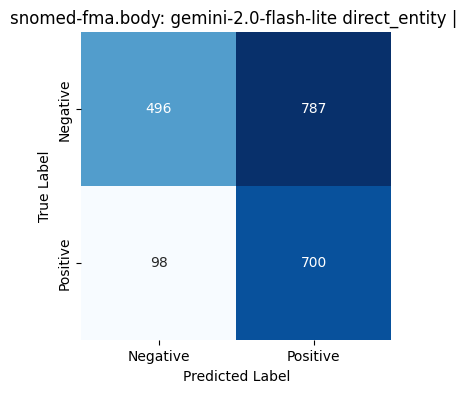

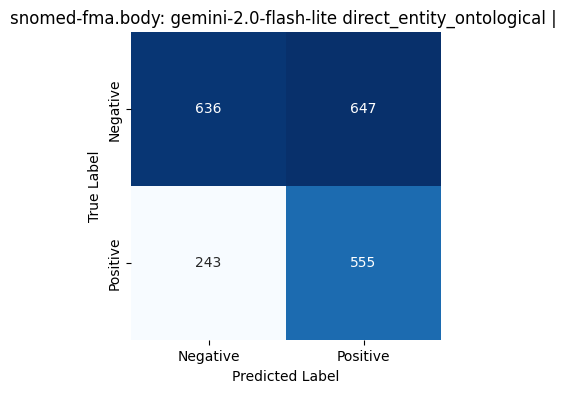

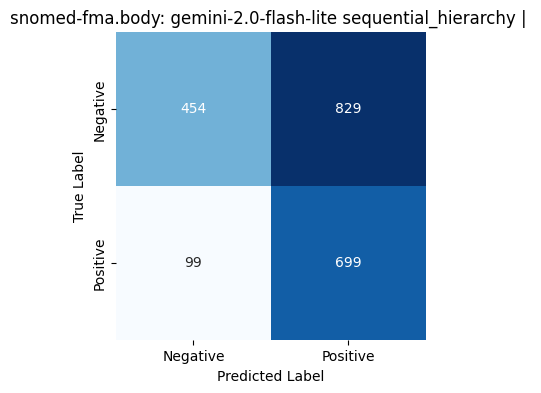

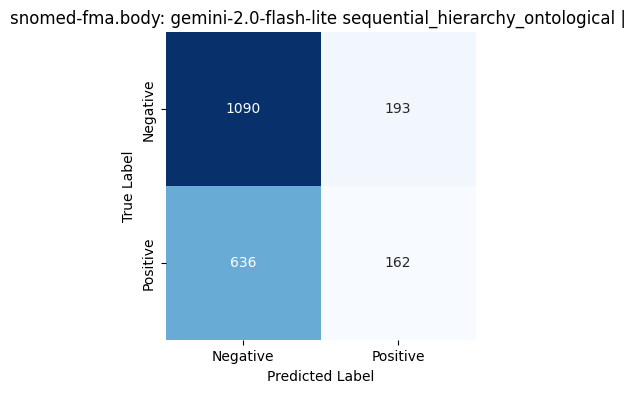

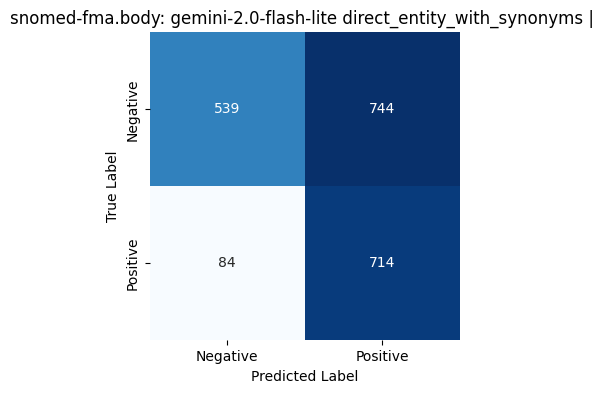

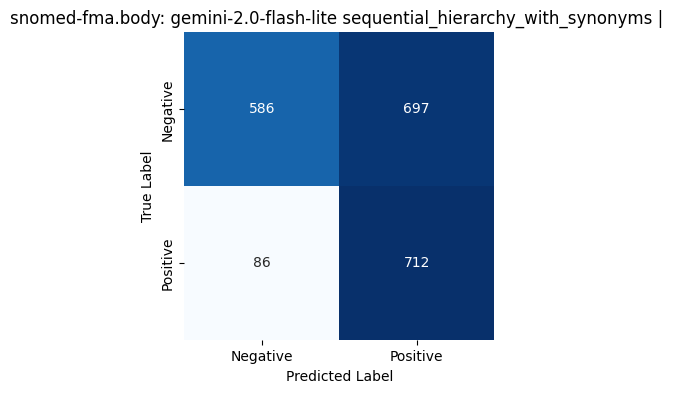

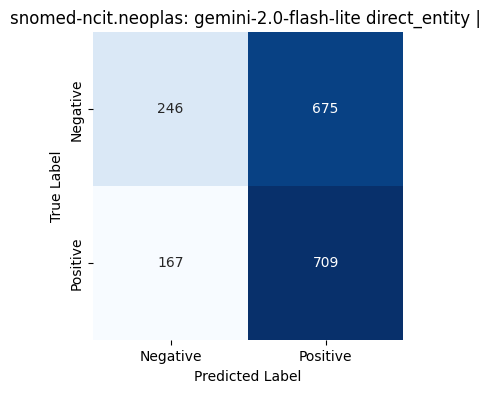

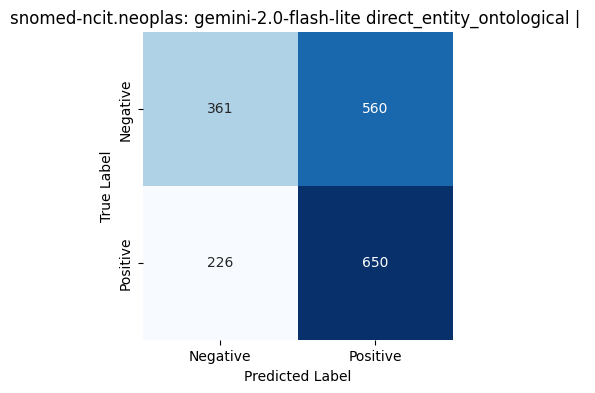

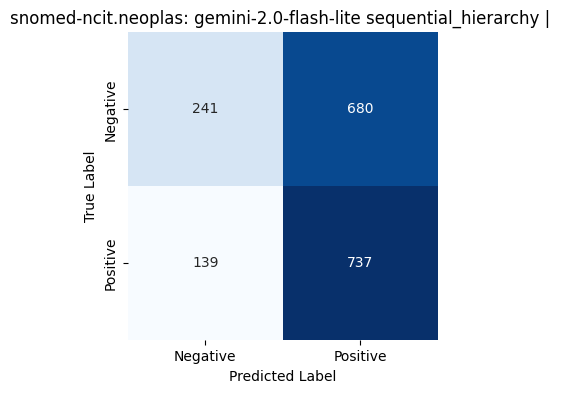

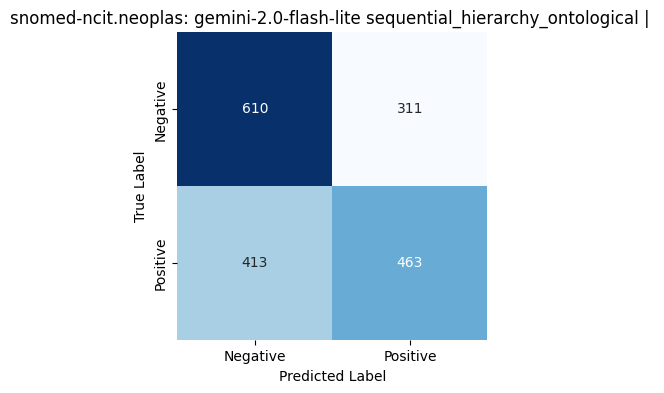

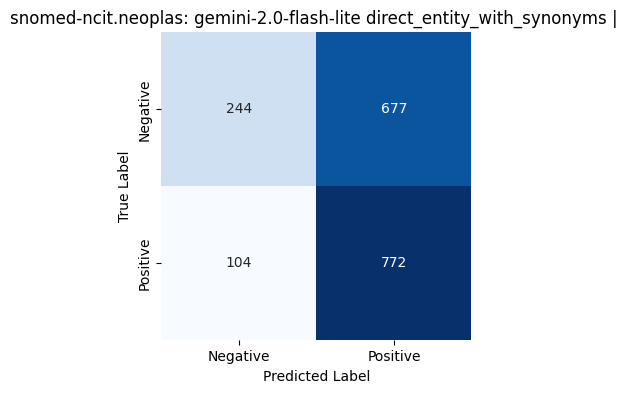

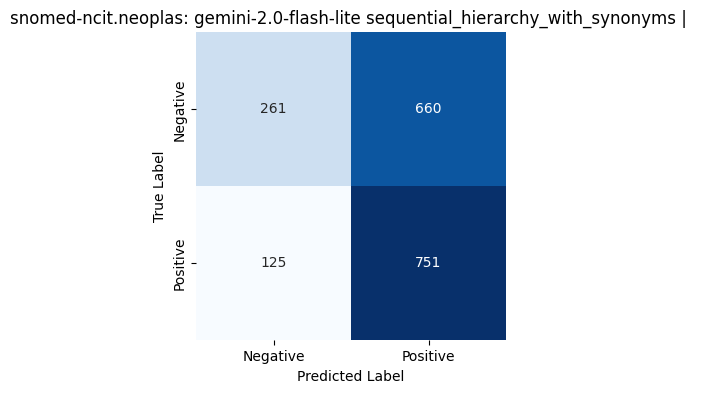

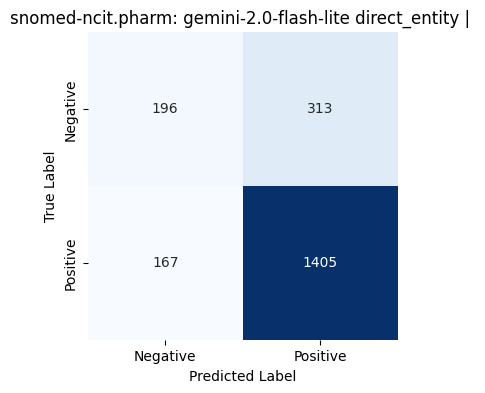

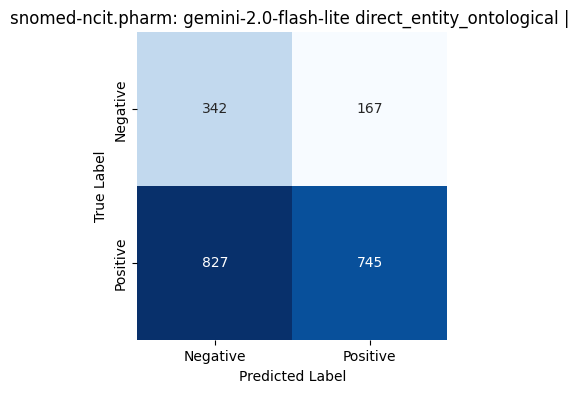

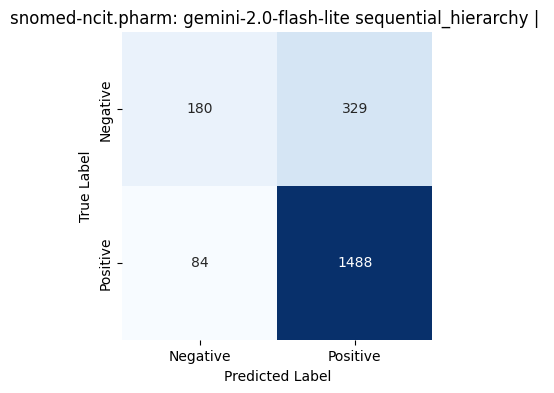

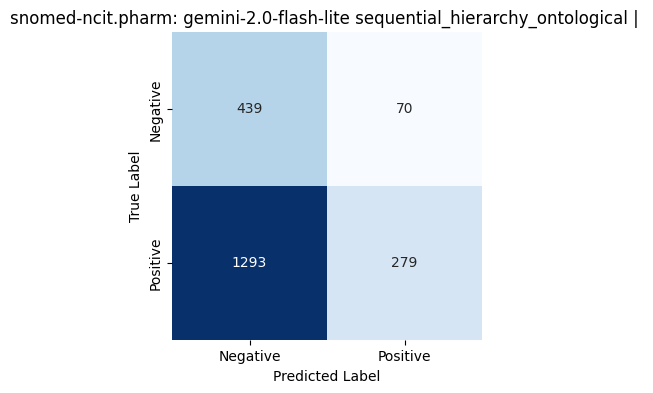

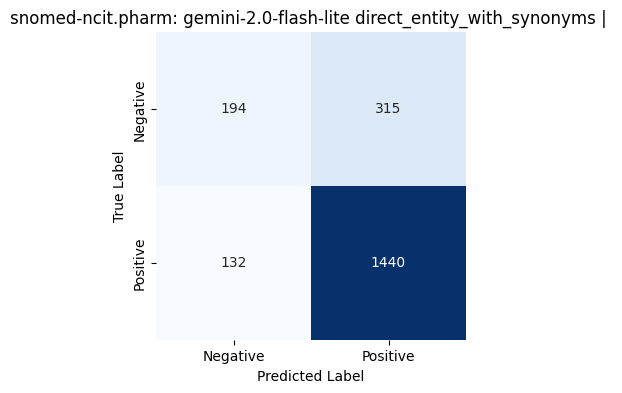

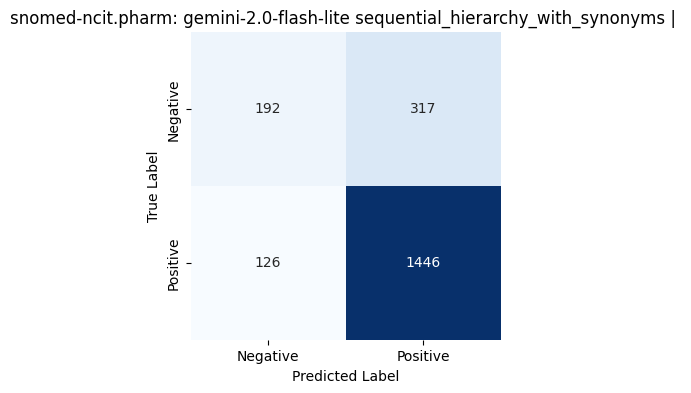

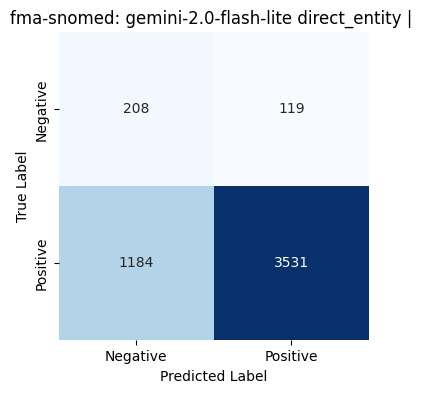

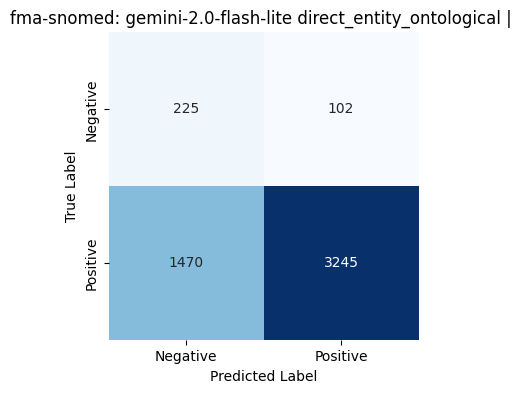

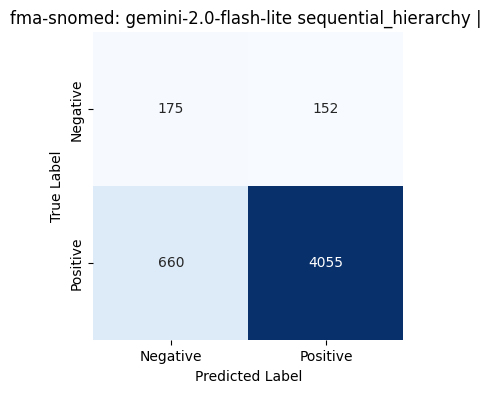

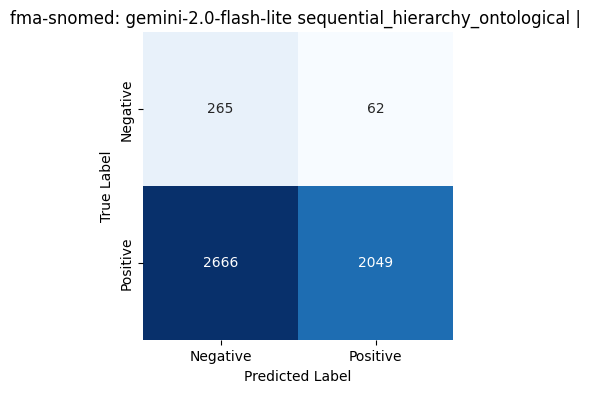

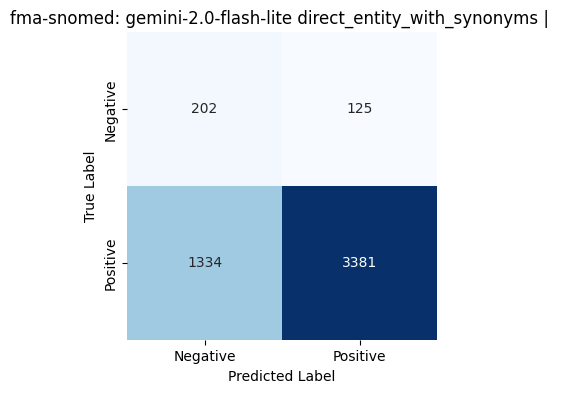

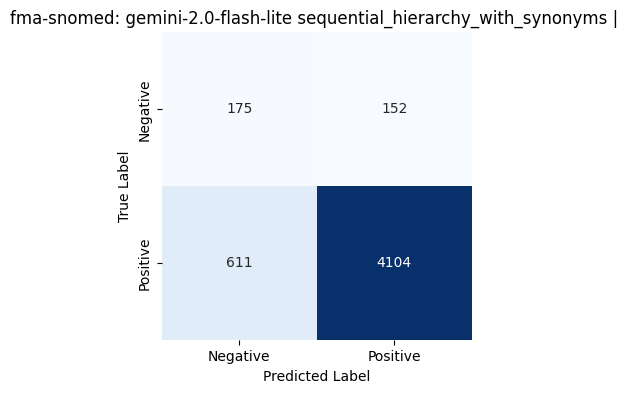

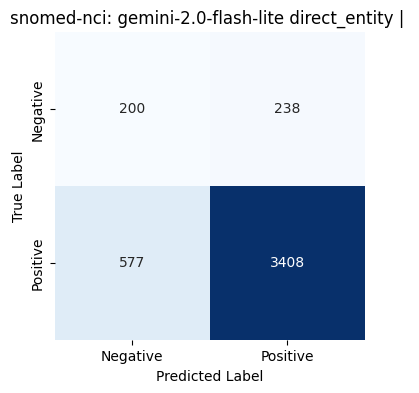

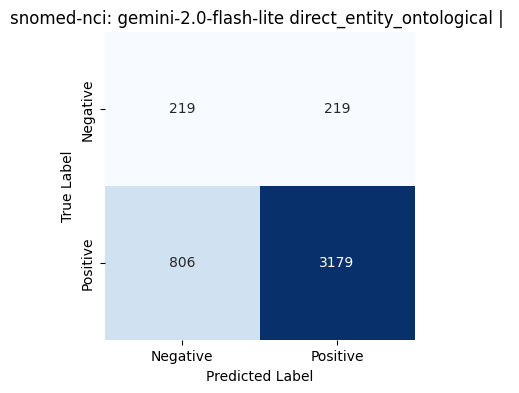

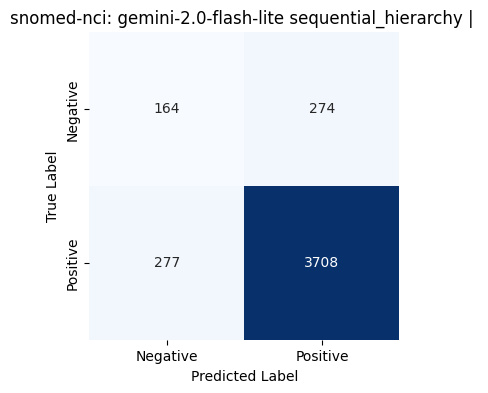

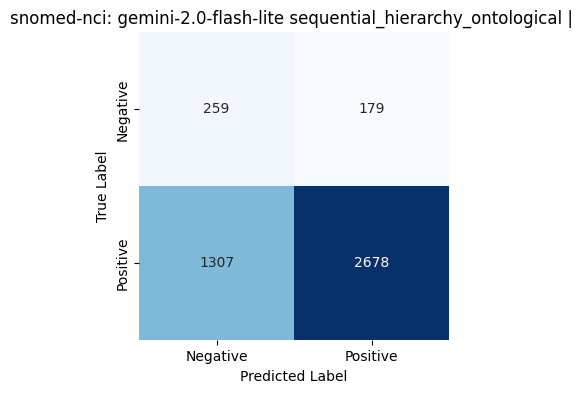

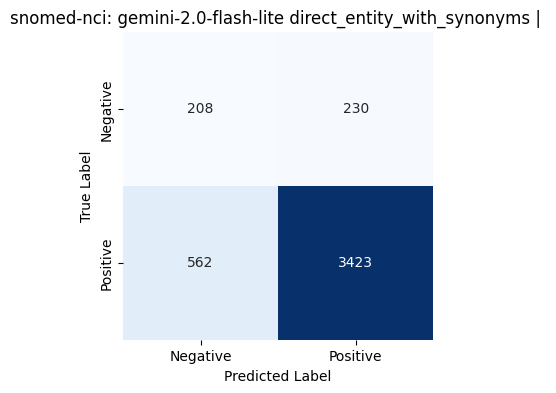

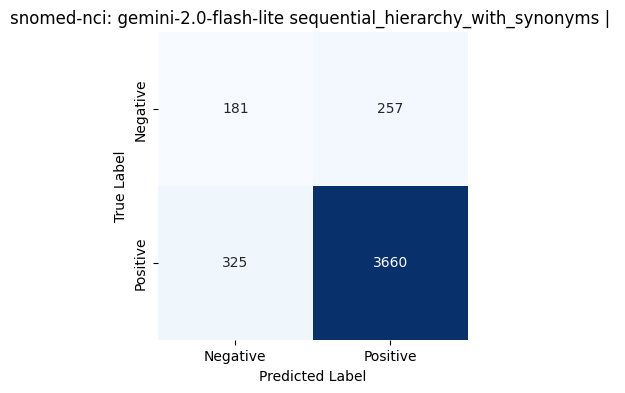

In [ ]:
for DATASET_NAME in DATASETS_MAP:
    for SET_NAME in DATASETS_MAP[DATASET_NAME]:
        for MODEL in MODELS:
            llm_oracle = (
                OpenAIServer(
                    api_key=os.environ["GEMINI_API_KEY"],
                    base_url="https://generativelanguage.googleapis.com/v1beta/openai/",
                )
                if MODEL.startswith("gemini")
                else OpenAIServer(api_key=os.environ["OPENAI_API_KEY"])
            )
            llm_oracle.add_system_context(BASELINE_INITIALIZATION_MESSAGE)

            run_path = format_run_path()
            print(f"Run path: {run_path}, dataset: {DATASET_NAME}, set: {SET_NAME}, model: {MODEL}")

            for current_exp_name, prompt_function in EXP_NAMES_TO_PROMPT_FUNCTIONS.items():
                oracle_candidate_pairs = load_precomputed_oracle_pairs(DATASET_NAME, SET_NAME, prompt_function)

                results, tokens_usage, confidences = parallel_samples_process(
                    oracle_candidate_pairs, llm_oracle, onto_src, onto_tgt, MODEL, MAX_WORKERS, prompt_function
                )
                prediction_path, stats_path, diagram_path = format_storing_pathes_from_run_path(
                    run_path, SET_NAME, MODEL, current_exp_name, suffix=""
                )
                save_run_results(results, prediction_path, columns=["Source", "Target", "Prediction", "Confidence"])
                plot_usage_histograms(
                    tokens_usage, confidences, do_plot=False, do_print=True, suptitle=current_exp_name
                )
                try:
                    predictions = get_predictions_with_gt(
                        run_path, DATASET_NAME, SET_NAME, MODEL, current_exp_name, suffix=""
                    )
                    analyze_results(
                        predictions,
                        print_results=True,
                        plot_confusion_matrix=False,
                        subtitle=f"{SET_NAME}: {MODEL} {current_exp_name} | ",
                        cm_save_path=diagram_path,
                        stats_path=stats_path,
                    )
                except Exception as e:  # noqa: BLE001
                    print(f"Error: {e}")

                print("\n")

            store_run_metrics_df(EXP_NAMES_TO_PROMPT_FUNCTIONS, run_path, DATASET_NAME, SET_NAME, MODEL)

## Analysis


In [17]:
runs_array = []

for directory in sorted(RUN_DIR.iterdir(), key=lambda x: x.name, reverse=True):
    if not directory.is_dir():
        continue
    for file in directory.iterdir():
        if '_' not in file.name:
            continue
        subset_name, model_name = file.name.split('_')[:2]
        dataset_name = SUBSET_TO_DATASET_MAP.get(subset_name)
    runs_array.append((directory.name, model_name, subset_name, dataset_name))

runs_array

[('2025-05-01_11-47-16', 'gemini-2.0-flash', 'snomed-nci', 'largebio'),
 ('2025-05-01_11-37-30', 'gemini-2.0-flash-lite', 'snomed-nci', 'largebio'),
 ('2025-05-01_11-24-31', 'gemini-2.0-flash', 'fma-snomed', 'largebio'),
 ('2025-05-01_11-19-48', 'gemini-2.0-flash-lite', 'fma-snomed', 'largebio'),
 ('2025-05-01_11-15-05',
  'gemini-2.0-flash',
  'snomed-ncit.pharm',
  'bioml-2024'),
 ('2025-05-01_11-12-35',
  'gemini-2.0-flash-lite',
  'snomed-ncit.pharm',
  'bioml-2024'),
 ('2025-05-01_11-07-00',
  'gemini-2.0-flash',
  'snomed-ncit.neoplas',
  'bioml-2024'),
 ('2025-05-01_11-06-39',
  'gemini-2.0-flash-lite',
  'snomed-ncit.neoplas',
  'bioml-2024'),
 ('2025-05-01_10-56-46', 'gemini-2.0-flash', 'snomed-fma.body', 'bioml-2024'),
 ('2025-05-01_10-50-33',
  'gemini-2.0-flash-lite',
  'snomed-fma.body',
  'bioml-2024'),
 ('2025-05-01_10-13-02', 'gemini-2.0-flash-lite', 'fma-snomed', 'largebio'),
 ('2025-04-30_23-58-50', 'gemini-2.0-flash', 'mouse-human', None),
 ('2025-04-10_22-11-36', 'g

In [ ]:
runs = [
    ('2025-05-01_11-47-16', 'gemini-2.0-flash', 'snomed-nci', 'largebio'),
    ('2025-05-01_11-37-30', 'gemini-2.0-flash-lite', 'snomed-nci', 'largebio'),
    ('2025-05-01_11-24-31', 'gemini-2.0-flash', 'fma-snomed', 'largebio'),
    ('2025-05-01_11-19-48', 'gemini-2.0-flash-lite', 'fma-snomed', 'largebio'),
    ('2025-05-01_11-15-05', 'gemini-2.0-flash', 'snomed-ncit.pharm', 'bioml-2024'),
    ('2025-05-01_11-12-35', 'gemini-2.0-flash-lite', 'snomed-ncit.pharm', 'bioml-2024'),
    ('2025-05-01_11-07-00', 'gemini-2.0-flash', 'snomed-ncit.neoplas', 'bioml-2024'),
    ('2025-05-01_11-06-39', 'gemini-2.0-flash-lite', 'snomed-ncit.neoplas', 'bioml-2024'),
    ('2025-05-01_10-56-46', 'gemini-2.0-flash', 'snomed-fma.body', 'bioml-2024'),
    ('2025-05-01_10-50-33', 'gemini-2.0-flash-lite', 'snomed-fma.body', 'bioml-2024'),
    ('2025-05-01_10-13-02', 'gemini-2.0-flash-lite', 'fma-snomed', 'largebio'),
    ('2025-04-10_22-11-36', 'gemini-2.0-flash', 'ncit-doid', 'bioml-2024'),
    ('2025-04-10_00-33-19', 'gemini-2.0-flash-lite', 'ncit-doid', 'bioml-2024'),
    ('2025-04-06_22-05-02', 'gemini-2.0-flash-lite', 'omim-ordo', 'bioml-2024'),
    ('2025-04-06_19-27-41', 'gemini-2.0-flash', 'omim-ordo', 'bioml-2024'),
    ('2025-04-06_14-51-00', 'gemini-2.0-flash-lite', 'fma-nci', 'largebio'),
    ('2025-04-06_14-18-46', 'gemini-2.0-flash', 'fma-nci', 'largebio'),
    ('2025-04-04_19-41-28', 'gemini-2.0-flash', 'human-mouse', 'anatomy'),
    ('2025-04-04_19-23-47', 'gemini-2.0-flash-lite', 'human-mouse', 'anatomy'),
    ('2025-04-04_00-43-16', 'gemini-2.0-flash', 'fma-snomed', 'largebio'),
    ('2025-03-28_10-15-04', 'gpt-4o-mini', 'fma-nci', 'largebio'),
    ('2025-03-19_23-32-20', 'gpt-4o-mini', 'omim-ordo', 'bioml-2024'),
    ('2025-03-19_22-17-52', 'gpt-4o-mini', 'ncit-doid', 'bioml-2024'),
    ('2025-03-19_19-48-41', 'gpt-4o-mini', 'human-mouse', 'anatomy'),
    ('2025-03-14_00-40-55', 'gpt-4o-mini', 'ncit-doid', 'bioml-2024'),
    ('2025-03-12_17-21-53', 'gpt-4o-mini', 'human-mouse', 'anatomy'),
    ('2025-03-12_14-43-32', 'gpt-4o-mini', 'omim-ordo', 'bioml-2024')
 ]

dfs = []

for run_subdir, model, set_name, dataset in runs:
    metrics_df = read_run_metrics_df(run_subdir)
    for col, value in zip(["Dataset", "SubSet", "Model"], [dataset, set_name, model]):
        if col not in metrics_df.columns:
            metrics_df[col] = value
    metrics_df["Run"] = run_subdir
    dfs.append(metrics_df)

results_df = pd.concat(dfs, ignore_index=True)
results_df = results_df.sort_values(by=["Dataset", "SubSet", "Model", "Experiment"])
pd.set_option("display.max_rows", None)

results_df

,Experiment,Accuracy,Precision,Recall,F1 Score,Dataset,SubSet,Model,Run
96,direct_entity,0.8392,0.8476,0.9521,0.8968,anatomy,human-mouse,gemini-2.0-flash,2025-04-04_19-41-28
97,direct_entity_ontological,0.8266,0.8495,0.9281,0.8871,anatomy,human-mouse,gemini-2.0-flash,2025-04-04_19-41-28
100,direct_entity_with_synonyms,0.8492,0.8392,0.9829,0.9054,anatomy,human-mouse,gemini-2.0-flash,2025-04-04_19-41-28
98,sequential_hierarchy,0.8442,0.8423,0.9692,0.9013,anatomy,human-mouse,gemini-2.0-flash,2025-04-04_19-41-28
99,sequential_hierarchy_ontological,0.7990,0.8354,0.9041,0.8684,anatomy,human-mouse,gemini-2.0-flash,2025-04-04_19-41-28
101,sequential_hierarchy_with_synonyms,0.8518,0.8416,0.9829,0.9068,anatomy,human-mouse,gemini-2.0-flash,2025-04-04_19-41-28
102,direct_entity,0.8090,0.9000,0.8322,0.8648,anatomy,human-mouse,gemini-2.0-flash-lite,2025-04-04_19-23-47
103,direct_entity_ontological,0.7186,0.8947,0.6986,0.7846,anatomy,human-mouse,gemini-2.0-flash-lite,2025-04-04_19-23-47
106,direct_entity_with_synonyms,0.8141,0.8283,0.9418,0.8814,anatomy,human-mouse,gemini-2.0-flash-lite,2025-04-04_19-23-47
104,sequential_hierarchy,0.8266,0.8495,0.9281,0.8871,anatomy,human-mouse,gemini-2.0-flash-lite,2025-04-04_19-23-47


In [21]:
results_df.to_csv(RUN_DIR / "all_runs_metrics.csv", index=False)